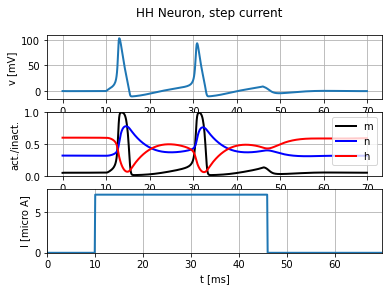

In [1]:
%matplotlib inline
import brian2 as b2
import matplotlib.pyplot as plt
import numpy as np
from neurodynex3.hodgkin_huxley import HH
from neurodynex3.tools import input_factory

HH.getting_started()

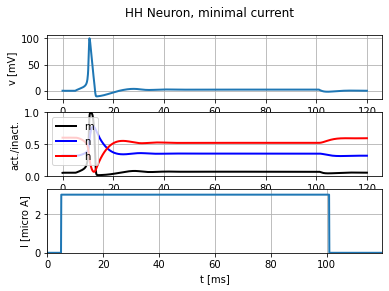

In [2]:
#The min seems to be about 3 µA to generate a single spike
I_min = 3

current = input_factory.get_step_current(5, 100, b2.ms, I_min *b2.uA)
state_monitor = HH.simulate_HH_neuron(current, 120 * b2.ms)
HH.plot_data(state_monitor, title="HH Neuron, minimal current")

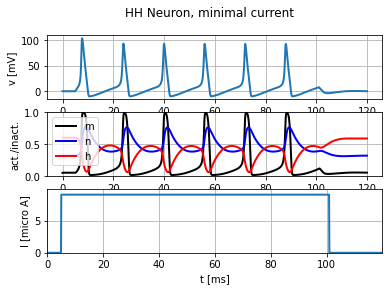

In [3]:
#The min seems to be about 9 µA to get a repetitive firing (train)
I_min = 9

current = input_factory.get_step_current(5, 100, b2.ms, I_min *b2.uA)
state_monitor = HH.simulate_HH_neuron(current, 120 * b2.ms)
HH.plot_data(state_monitor, title="HH Neuron, minimal current")

We see the alternative activation and inactivation of the ion channels in the repetitive firing case. Otherwise the general profile is basically the same

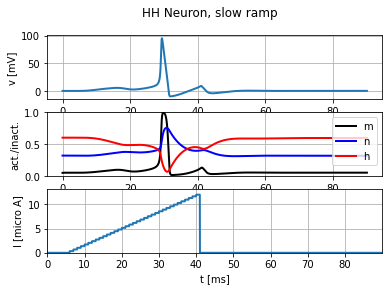

voltage_slow=0.005999699979620661


In [12]:
#For a ramp of taking about 50 ms, no spike is generated. If we have a
#shorter ramp (40), the spike is generated.
b2.defaultclock.dt = 0.02*b2.ms
slow_ramp_t_end = 40  # no spike. make it shorter
slow_ramp_current = input_factory.get_ramp_current(5, slow_ramp_t_end, b2.ms, 0.*b2.uA, 12.0*b2.uA)
state_monitor = HH.simulate_HH_neuron(slow_ramp_current, 90 * b2.ms)
idx_t_end = int(round(slow_ramp_t_end*b2.ms / b2.defaultclock.dt))
voltage_slow = state_monitor.vm[0,idx_t_end]
HH.plot_data(state_monitor, title="HH Neuron, slow ramp")
print("voltage_slow={}".format(voltage_slow))

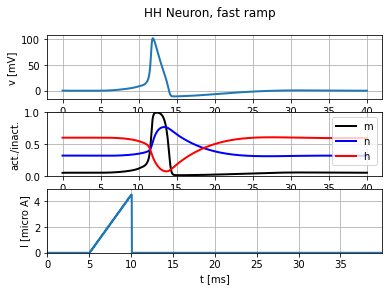

voltage_fast=0.00841684828231669


In [5]:
b2.defaultclock.dt = 0.02*b2.ms
fast_ramp_t_end = 100  # no spike. make it longer
fast_ramp_current = input_factory.get_ramp_current(50, fast_ramp_t_end, 0.1*b2.ms, 0.*b2.uA, 4.5*b2.uA)
state_monitor = HH.simulate_HH_neuron(fast_ramp_current, 40 * b2.ms)
idx_t_end = int(round(fast_ramp_t_end*0.1*b2.ms / b2.defaultclock.dt))
voltage_fast = state_monitor.vm[0,idx_t_end]
HH.plot_data(state_monitor, title="HH Neuron, fast ramp")
print("voltage_fast={}".format(voltage_fast))

See a spike for about 10 ms, the voltage is about the same as before.

The thresholds are different because a slow ramp gives time to both channels to open (all gating variables activate), while the fast ramp only activates m before the other 2, so that the spike is generated before.

If the current is too fast (ramp too short), even the m variable doesn't have time to fully increase to 1, so no spike is generated for too short pulses. If we decrease the slope a little bit, the spike is generated

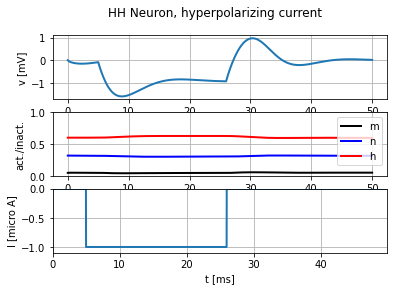

In [6]:
I_amp = -1

current = input_factory.get_step_current(5, 25, b2.ms, I_amp *b2.uA)
state_monitor = HH.simulate_HH_neuron(current, 50 * b2.ms)
HH.plot_data(state_monitor, title="HH Neuron, hyperpolarizing current")

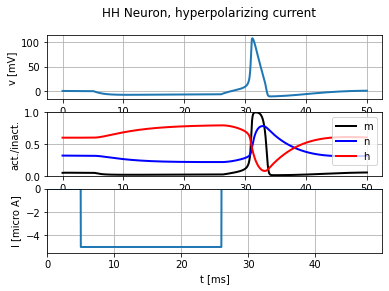

In [7]:
I_amp = -5

current = input_factory.get_step_current(5, 25, b2.ms, I_amp *b2.uA)
state_monitor = HH.simulate_HH_neuron(current, 50 * b2.ms)
HH.plot_data(state_monitor, title="HH Neuron, hyperpolarizing current")

We see very clearly a rebound spike happening when we stop injecting the negative current. It is due to the h gating variable associated to Potassium. The idea is that when imposing a long negative current, the gating variables get used to this new influx and attain a certain equilibrium (on the inside of the membrane). Then we stop it, so it's the same as having a short positive pulse on the other side of the membrane, which triggers a spike as before. This is due to the h variable increasing and opening the potassium channel, which creates a negative gradient of ions wrt before.

In [8]:
def my_simulate_HH_neuron(input_current, simulation_time):

    """A Hodgkin-Huxley neuron implemented in Brian2.

    Args:
        input_current (TimedArray): Input current injected into the HH neuron
        simulation_time (float): Simulation time [seconds]

    Returns:
        StateMonitor: Brian2 StateMonitor with recorded fields
        ["vm", "I_e", "m", "n", "h"]
    """

    # neuron parameters
    El = 10.6 * b2.mV
    EK = -12 * b2.mV
    ENa = 115 * b2.mV
    gl = 0.3 * b2.msiemens
    gK = 36 * b2.msiemens
    gNa = 120 * 1.4 * b2.msiemens
    C = 1 * b2.ufarad

    # forming HH model with differential equations
    eqs = """
    I_e = input_current(t,i) : amp
    membrane_Im = I_e + gNa*m**3*h*(ENa-vm) + \
        gl*(El-vm) + gK*n**4*(EK-vm) : amp
    alphah = .07*exp(-.05*vm/mV)/ms    : Hz
    alpham = .1*(25*mV-vm)/(exp(2.5-.1*vm/mV)-1)/mV/ms : Hz
    alphan = .01*(10*mV-vm)/(exp(1-.1*vm/mV)-1)/mV/ms : Hz
    betah = 1./(1+exp(3.-.1*vm/mV))/ms : Hz
    betam = 4*exp(-.0556*vm/mV)/ms : Hz
    betan = .125*exp(-.0125*vm/mV)/ms : Hz
    dh/dt = alphah*(1-h)-betah*h : 1
    dm/dt = alpham*(1-m)-betam*m : 1
    dn/dt = alphan*(1-n)-betan*n : 1
    dvm/dt = membrane_Im/C : volt
    """

    neuron = b2.NeuronGroup(1, eqs, method="exponential_euler")

    # parameter initialization
    neuron.vm = 0
    neuron.m = 0.05
    neuron.h = 0.60
    neuron.n = 0.32

    # tracking parameters
    st_mon = b2.StateMonitor(neuron, ["vm", "I_e", "m", "n", "h"], record=True)

    # running the simulation
    hh_net = b2.Network(neuron)
    hh_net.add(st_mon)
    hh_net.run(simulation_time)

    return st_mon

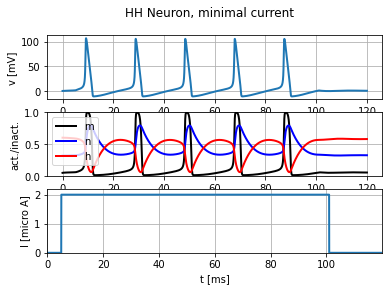

In [9]:
#Now the minimal current for repetitive firing is much smaller (2 << 6)
I_min = 2

current = input_factory.get_step_current(5, 100, b2.ms, I_min *b2.uA)
state_monitor = my_simulate_HH_neuron(current, 120 * b2.ms)
HH.plot_data(state_monitor, title="HH Neuron, minimal current")

Much smaller min current for repetitive firing, probably because we increased the density of sodium channels (gNa), and so we increase the effect of the Na channels, so we don't need much input to generate the spikes, alternatively the conductance directly appears in the equation as a proportionality constant. With even bigger conductance, it's like the channels are always open => repetitive firing

WARNING    /home/thomas/miniconda3/envs/bmnn/lib/python3.10/site-packages/neurodynex3/hodgkin_huxley/HH.py:61: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  plt.axis((
 [py.warnings]


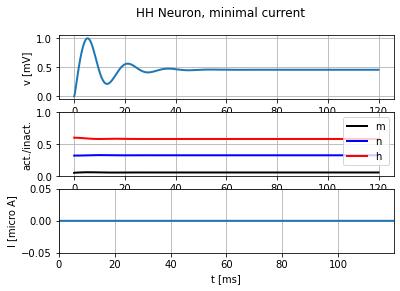

In [10]:
I_min = 0

current = input_factory.get_step_current(5, 100, b2.ms, I_min *b2.uA)
state_monitor = my_simulate_HH_neuron(current, 120 * b2.ms)
HH.plot_data(state_monitor, title="HH Neuron, minimal current")